<a href="https://colab.research.google.com/github/sruby8/uplift.ai/blob/master/Kinematics_Kinetic_pitch_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

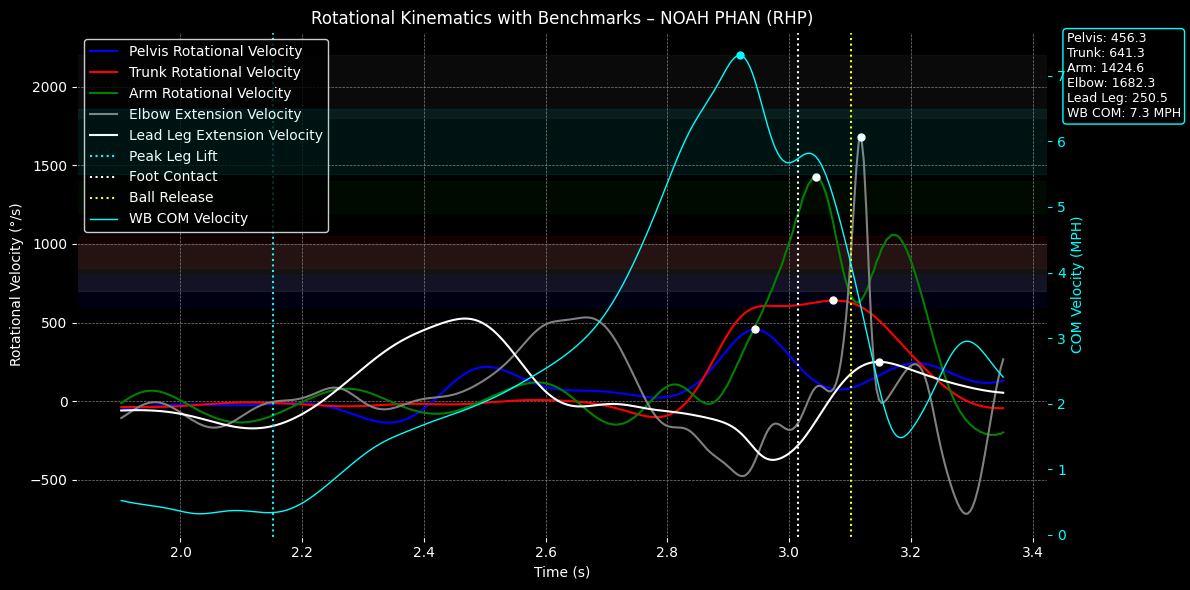

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.signal import savgol_filter

# Load dataset
file_path = "/content/uplift_data_export_20250604135402.csv"
data = pd.read_csv(file_path)

# Define column names
athlete_name_col = "athlete_name"
handedness_col = "handedness"
trunk_velocity_col = "trunk_rotational_velocity_with_respect_to_ground"
pelvis_velocity_col = "pelvis_rotational_velocity_with_respect_to_ground"
left_arm_velocity_col = "left_arm_rotational_velocity_with_respect_to_ground"
right_arm_velocity_col = "right_arm_rotational_velocity_with_respect_to_ground"
left_elbow_velocity_col = "left_elbow_flexion_velocity"
right_elbow_velocity_col = "right_elbow_flexion_velocity"
right_knee_velocity_col = "right_knee_extension_velocity"
left_knee_velocity_col = "left_knee_extension_velocity"
foot_contact_time_col = "foot_contact_time"
ball_release_time_col = "ball_release_time"
time_col = "time"

# Extract athlete name and determine handedness
athlete_name_chart = re.sub(r"[^A-Z\s]", "", data[athlete_name_col].iloc[0].upper())
pitcher_handedness = data[handedness_col].iloc[0].lower()
pitcherhand = "LHP" if pitcher_handedness == "left" else "RHP"

# Select appropriate columns based on handedness
arm_velocity_col = left_arm_velocity_col if pitcherhand == "LHP" else right_arm_velocity_col
elbow_velocity_col = left_elbow_velocity_col if pitcherhand == "LHP" else right_elbow_velocity_col
lead_leg_velocity_col = right_knee_velocity_col if pitcherhand == "LHP" else left_knee_velocity_col

# Create subset and compute smoothed COM velocity
subset_data = data[[time_col, trunk_velocity_col, pelvis_velocity_col, arm_velocity_col,
                    elbow_velocity_col, lead_leg_velocity_col, foot_contact_time_col, ball_release_time_col,
                    'whole_body_center_of_mass_x', 'whole_body_center_of_mass_y', 'whole_body_center_of_mass_z']].copy()

fps = data['fps'].iloc[0]
dt = 1 / fps

x_smooth = savgol_filter(data['whole_body_center_of_mass_x'], 11, 3)
y_smooth = savgol_filter(data['whole_body_center_of_mass_y'], 11, 3)
z_smooth = savgol_filter(data['whole_body_center_of_mass_z'], 11, 3)

vx = np.gradient(x_smooth, dt)
vy = np.gradient(y_smooth, dt)
vz = np.gradient(z_smooth, dt)
com_velocity_mph = np.sqrt(vx**2 + vy**2 + vz**2) * 2.23694
subset_data['wb_com_total_velocity_mph'] = com_velocity_mph

# Rename and normalize columns
subset_data = subset_data.rename(columns={
    pelvis_velocity_col: "pelvis_velocity",
    trunk_velocity_col: "trunk_velocity",
    arm_velocity_col: "arm_velocity",
    lead_leg_velocity_col: "lead_leg_extension_velocity",
    elbow_velocity_col: "elbow_velocity"
})

if pitcherhand == "LHP":
    subset_data[["pelvis_velocity", "trunk_velocity", "arm_velocity", "lead_leg_extension_velocity"]] *= -1
subset_data["elbow_velocity"] *= -1

# Extract time markers
foot_contact_time = subset_data.loc[subset_data["foot_contact_time"] == 0.0, "time"].min()
ball_release_time = subset_data.loc[subset_data["ball_release_time"] == 0.0, "time"].min()
peak_leg_lift_time = data.loc[data['max_knee_raise_frame'] == 0, "time"].min()

# Trim window
start_time = peak_leg_lift_time - 0.25
end_time = ball_release_time + 0.25
trimmed_data = subset_data[(subset_data["time"] >= start_time) & (subset_data["time"] <= end_time)]

# Define peak detection function
def get_peak_in_window(df, col, start, end):
    window = df[(df["time"] >= start) & (df["time"] <= end)]
    if window.empty:
        return None, None
    idx = window[col].idxmax()
    return df["time"].loc[idx], df[col].loc[idx]

# Peak windows
pre_contact_window = (foot_contact_time - 0.15, foot_contact_time + 0.15)
arm_window = (foot_contact_time, ball_release_time + 0.15)
lead_leg_window = (ball_release_time - 0.1, ball_release_time + 0.15)

# Extract peaks
peak_annotations = {
    "Pelvis": get_peak_in_window(trimmed_data, "pelvis_velocity", *pre_contact_window),
    "Trunk": get_peak_in_window(trimmed_data, "trunk_velocity", *pre_contact_window),
    "Arm": get_peak_in_window(trimmed_data, "arm_velocity", *arm_window),
    "Elbow": get_peak_in_window(trimmed_data, "elbow_velocity", *arm_window),
    "Lead Leg": get_peak_in_window(trimmed_data, "lead_leg_extension_velocity", *lead_leg_window),
    "WB COM": get_peak_in_window(trimmed_data, "wb_com_total_velocity_mph", start_time, end_time)
}

# Pro benchmark bands
benchmark_bands = {
    "pelvis_velocity": (600, 800),
    "trunk_velocity": (850, 1050),
    "arm_velocity": (1200, 1400),
    "elbow_velocity": (1800, 2200),
    "lead_leg_extension_velocity": (700, 1000),
    "wb_com_total_velocity_mph": (5.5, 6.5)
}
benchmark_colors = {
    "pelvis_velocity": "blue",
    "trunk_velocity": "red",
    "arm_velocity": "green",
    "elbow_velocity": "gray",
    "lead_leg_extension_velocity": "white",
    "wb_com_total_velocity_mph": "cyan"
}

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6), facecolor="black")
ax1.set_facecolor("black")

# Plot primary metrics
ax1.plot(trimmed_data["time"], trimmed_data["pelvis_velocity"], color="blue", label="Pelvis Rotational Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["trunk_velocity"], color="red", label="Trunk Rotational Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["arm_velocity"], color="green", label="Arm Rotational Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["elbow_velocity"], color="gray", label="Elbow Extension Velocity")
ax1.plot(trimmed_data["time"], trimmed_data["lead_leg_extension_velocity"], color="white", label="Lead Leg Extension Velocity")

# Benchmark bands (primary Y-axis)
for metric in ["pelvis_velocity", "trunk_velocity", "arm_velocity", "elbow_velocity", "lead_leg_extension_velocity"]:
    low, high = benchmark_bands[metric]
    ax1.axhspan(low, high, color=benchmark_colors[metric], alpha=0.08)

# Event markers
ax1.axvline(peak_leg_lift_time, color="cyan", linestyle="dotted", label="Peak Leg Lift")
ax1.axvline(foot_contact_time, color="white", linestyle="dotted", label="Foot Contact")
ax1.axvline(ball_release_time, color="yellow", linestyle="dotted", label="Ball Release")

# Annotate peaks
for label, (t, val) in peak_annotations.items():
    if pd.notna(t) and pd.notna(val) and label != "WB COM":
        ax1.plot(t, val, 'o', color="white", markersize=5)

# Secondary Y-axis for COM velocity
ax2 = ax1.twinx()
ax2.plot(trimmed_data["time"], trimmed_data["wb_com_total_velocity_mph"], color="cyan", label="WB COM Velocity", linewidth=1.0)
if pd.notna(peak_annotations["WB COM"][0]) and pd.notna(peak_annotations["WB COM"][1]):
    ax2.plot(peak_annotations["WB COM"][0], peak_annotations["WB COM"][1], 'o', color="cyan", markersize=5)

# COM benchmark band
low, high = benchmark_bands["wb_com_total_velocity_mph"]
ax2.axhspan(low, high, color=benchmark_colors["wb_com_total_velocity_mph"], alpha=0.08)

# Summary legend
summary_text = "\n".join([
    f"{k}: {v[1]:.1f}{' MPH' if k == 'WB COM' else ''}" for k, v in peak_annotations.items() if pd.notna(v[1])
])
ax1.text(1.02, 1.0, summary_text, transform=ax1.transAxes, fontsize=9,
         verticalalignment='top', color='white', bbox=dict(boxstyle="round", facecolor="black", edgecolor="cyan"))

# Styling
ax1.set_xlabel("Time (s)", color="white")
ax1.set_ylabel("Rotational Velocity (°/s)", color="white")
ax2.set_ylabel("COM Velocity (MPH)", color="cyan")
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='y', colors='cyan')
ax1.grid(color="gray", linestyle="--", linewidth=0.5)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", facecolor="black", edgecolor="white", labelcolor="white")

plt.title(f"Rotational Kinematics with Benchmarks – {athlete_name_chart} ({pitcherhand})", color="white")
plt.tight_layout()
plt.show()